In [1]:
import time
import numpy as np

from gru_model import GL_model
import torch
from torch import optim
from util import bce_loss, accuracy_function
from Paras import Para

from data_loader import l_train_loader, l_validation_loader, l_test_loader

In [2]:
Para.MODEL_SAVE_PATH_2B

'../model/best_model_2b.pt'

In [3]:
Para.dataset_len = len(l_train_loader)
Para.log_step = len(l_train_loader) // 4
Para.epoch_num = 40

optimizer = torch.optim.RMSprop(GL_model.parameters(), lr=1e-5)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.5)


def train(model, epoch, versatile=True):
    start_time = time.time()
    model = model.train()
    train_loss = 0.
    accuracy = 0.
    batch_num = len(l_train_loader)
    _index = 0

    for _index, data in enumerate(l_train_loader):
        spec_input, target = data['mel'], data['tag']

        if Para.cuda:
            spec_input = spec_input.cuda()
            target = target.cuda()

        optimizer.zero_grad()
        predicted = model(spec_input)

        loss_value = bce_loss(predicted, target)
        accuracy_value = accuracy_function(predicted, target)

        loss_value.backward()
        optimizer.step()

        train_loss += loss_value.data.item()
        accuracy += accuracy_value

        if versatile:
            if (_index + 1) % Para.log_step == 0:
                elapsed = time.time() - start_time
                print('Epoch{:3d} | {:3d}/{:3d} batches | {:5.2f}ms/ batch | BCE: {:5.4f} | Accuracy: {:5.2f}% |'
                      .format(epoch, _index + 1, batch_num,
                              elapsed * 1000 / (_index + 1),
                              train_loss / (_index + 1),
                              accuracy * 100 / (_index + 1)))

    train_loss /= (_index + 1)
    accuracy /= (_index + 1)

    print('-' * 99)
    print('End of training epoch {:3d} | time: {:5.2f}s | BCE: {:5.4f} | Accuracy: {:5.2f}% |'
          .format(epoch, (time.time() - start_time),
                  train_loss, accuracy * 100))

    return train_loss, accuracy


def validate_test(model, epoch, test=False):
    start_time = time.time()
    model = model.eval()
    v_loss = 0.
    accuracy = 0.
    data_loader_use = l_validation_loader if not test else l_test_loader
    _index = 0
    for _index, data in enumerate(data_loader_use):
        spec_input, target = data['mel'], data['tag']

        if Para.cuda:
            spec_input = spec_input.cuda()
            target = target.cuda()

        with torch.no_grad():

            predicted = model(spec_input)

            loss_value = bce_loss(predicted, target)
            accuracy_value = accuracy_function(predicted, target)

            v_loss += loss_value.data.item()
            accuracy += accuracy_value

    v_loss /= (_index + 1)
    accuracy /= (_index + 1)

    if not test:
        print('End of validation epoch {:3d} | time: {:5.2f}s | BCE: {:5.4f} | Accuracy: {:5.2f}% |'
              .format(epoch, (time.time() - start_time),
                v_loss, accuracy * 100))
    else:
        print('End of Test | time: {:5.2f}s | BCE: {:5.4f} | Accuracy: {:5.2f}% |'
              .format((time.time() - start_time),
                v_loss, accuracy * 100))
    print('-' * 99)

    return v_loss, accuracy

# Train the model here

In [9]:
# t_loss, t_accu, v_loss, v_accu = [], [], [], []
# decay_cnt = 0

for epoch in range(1, 10 + 1):
    if Para.cuda:
        GL_model.cuda()

    train_loss, train_accuracy = train(GL_model, epoch)
    validation_loss, validation_accuracy = validate_test(GL_model, epoch, test=False)

    t_loss.append(train_loss)
    t_accu.append(train_accuracy)

    v_loss.append(validation_loss)
    v_accu.append(validation_accuracy)

    # use accuracy to find the best model
    if np.max(t_accu) == t_accu[-1]:
        print('***Found Best Training Model***')
    if np.max(v_accu) == v_accu[-1]:
        with open('../model/best_model_2b_big_batch.pt', 'wb') as f:
            torch.save(GL_model.cpu().state_dict(), f)
            print('***Best Validation Model Found and Saved***')

    print('-' * 99)

    # Use BCE loss value for learning rate scheduling
    decay_cnt += 1

    if np.min(t_loss) not in t_loss[-3:] and decay_cnt > 2:
        scheduler.step()
        decay_cnt = 0
        print('***Learning rate decreased***')
        print('-' * 99)

Epoch  1 |  35/142 batches | 125.39ms/ batch | BCE: 0.0187 | Accuracy: 97.23% |
Epoch  1 |  70/142 batches | 124.05ms/ batch | BCE: 0.0186 | Accuracy: 97.28% |
Epoch  1 | 105/142 batches | 123.53ms/ batch | BCE: 0.0199 | Accuracy: 96.99% |
Epoch  1 | 140/142 batches | 123.27ms/ batch | BCE: 0.0201 | Accuracy: 96.99% |
---------------------------------------------------------------------------------------------------
End of training epoch   1 | time: 17.49s | BCE: 0.0201 | Accuracy: 97.01% |
End of validation epoch   1 | time:  0.73s | BCE: 0.0826 | Accuracy: 85.09% |
---------------------------------------------------------------------------------------------------
***Found Best Training Model***
***Best Validation Model Found and Saved***
---------------------------------------------------------------------------------------------------
Epoch  2 |  35/142 batches | 124.99ms/ batch | BCE: 0.0151 | Accuracy: 98.57% |
Epoch  2 |  70/142 batches | 123.79ms/ batch | BCE: 0.0182 | Accuracy:

In [10]:
import matplotlib.pyplot as plt

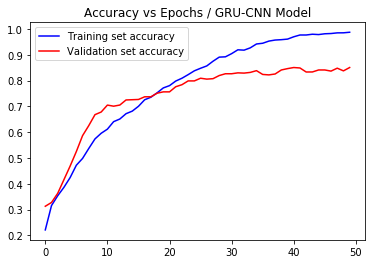

In [11]:
plt.figure()
plt.plot(t_accu, c='b', label='Training set accuracy')
plt.plot(v_accu, c='r', label='Validation set accuracy')
plt.title('Accuracy vs Epochs / GRU-CNN Model')
plt.legend()
plt.show()

In [12]:
store_dict = dict()
store_dict['train_a'] = t_accu
store_dict['train_l'] = t_loss
store_dict['valid_a'] = v_accu
store_dict['valid_l'] = v_loss

In [13]:
import json
with open('train_on_new_CRNN_big_batch.json', 'w+') as f:
    json.dump(store_dict, f)

In [18]:
GL_model.load_state_dict(torch.load('../model/best_model_2b_big_batch.pt'))
validate_test(GL_model.cuda(), 0, test=True)

End of Test | time:  0.76s | BCE: 0.1383 | Accuracy: 81.19% |
---------------------------------------------------------------------------------------------------


(0.13826735441883406, 0.8119212962962963)